In [1]:
#puts above directory into the path
import sys
sys.path.append("../../VREP_robot")
sys.path.append("../../VREP_robot/utils")
sys.path.append("../")
import vrep
from vrepRobot import *

from forwardKinematics import robot_config
import numpy as np
import time

pi = np.pi

In [2]:
# myRobot = robot_config()
# vrep_env = VREP_Environement()
# robot_handles  = ['pose_j0', 'pose_j1', 'pose_j2', 'pose_j3', 'pose_j4', 'pose_j5', 'pose_j6', 'pose_j7']
# vrep_env.add_robot(VREP_Robot('robot', robot_handles))
# vrep_env.start_simulation()

In [3]:
# setup environment
myRobot = robot_config()
# vrep_env = VREP_Environement(synchronous=False)
vrep_env = VREP_Environement(synchronous=True)
ik_handles = ['ik_joint1', 'ik_joint2', 'ik_joint3', 'ik_joint4', 'ik_joint5', 'ik_joint6', 'ik_joint7', 'ik_ee', 'kinematicsTest_IKTip', 'ik_rf7_static']
vrep_env.add_robot(VREP_Robot('ik_robot', ik_handles, connection_type = 'nonblocking'))
vrep_env.start_simulation()

Connected to remote API server
In synchronous mode
1 robot(s) connected: ['ik_robot']


In [4]:
# start = time.time()

# while time.time() - start < 18:
#     dt = time.time() - start
#     a = np.sin(dt)*0.5
#     q = np.array([0.2, -2.5, 0., 0., 0., 0., 0. + a])
#     positions = np.zeros((8,3))
#     positions[1:,:] = (myRobot.forwardKinPos(q))
#     orientations = np.zeros((8, 4)) #4 for quat
#     orientations[0,-1] = 1

#     print('Forward kinematic positions: {}'.format(positions))
#     orientations[1:,:] = myRobot.forwardKinOrientation(q)
#     print('Forward kinematic orientations: {}'.format(orientations))

#     print(vrep_env.robot.handle_names)
#     for i in range(len(robot_handles)):
#         vrep_env.robot.setObjectPosition(vrep_env.robot.handles[i], positions[i])
#         vrep_env.robot.setObjectQuaternion(vrep_env.robot.handles[i], orientations[i])
        
#     time.sleep(0.2)

In [5]:
#JEE = myRobot.J('EE', q)
#print("analytic jacobian: \n{}".format(JEE))

In [6]:
vrep_env.ik_robot.getCollisionHandle('Collision')
time.sleep(1)

In [7]:
# initialize collision check
# !!!important
vrep_env.ik_robot.getCollisionState(initialize=True)
vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)
vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static',initialize=True)

(1, [0.0, 0.0, 0.0, 0.0])

In [93]:
# generate config samples
from configGenerator_VREP import configGenerator_VREP
config = configGenerator_VREP.generate_sample(10)  # !!!set sample number here
total_config = config.shape[0]
print("total configs = ", total_config)
print(config)
print(total_config/50/3600)

joint lower limit
 [-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528 -0.90757121
  0.        ]
joint upper limit
 [0.1        0.905      1.57079633 0.90757121 0.90408055 0.90757121
 0.055     ]
total configs =  1000000
[[-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528 -0.90757121]
 [-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528 -0.70588872]
 [-0.1        -0.045      -1.57079633 -0.90757121 -0.87615528 -0.50420623]
 ...
 [ 0.1         0.905       1.57079633  0.90757121  0.90408055  0.50420623]
 [ 0.1         0.905       1.57079633  0.90757121  0.90408055  0.70588872]
 [ 0.1         0.905       1.57079633  0.90757121  0.90408055  0.90757121]]
5.555555555555555


In [94]:
# initialize collision state placeholder
y = np.zeros((total_config))
EEPosition = np.zeros((total_config,3))
EEOrientation = np.zeros((total_config,3))
EEQuaternion = np.zeros((total_config,4))

In [95]:
# collision detect
from tqdm import tqdm_notebook as tqdm

pbar = tqdm(total=total_config)  # set progress bar

t = time.clock()
for i in range(total_config):
#for i in range(len(jointAngle)):
    joint_angle = config[i, :]
    for j in range(6):
        vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[j], joint_angle[j])
    #vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[5], jointAngle[i])
    
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    #time.sleep(1)
    collisionState = vrep_env.ik_robot.getCollisionState()
    #print(collisionState)
    y[i] = collisionState
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    #vrep.simxGetPingTime(vrep_env.clientID)
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEOrientation[i,:] = vrep_env.ik_robot.getObjectOrientation(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    EEQuaternion[i,:] = vrep_env.ik_robot.getObjectQuaternion(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    pbar.update(1)
#     time.sleep(0.5)
    #print(EEPosition[i,:])
    
    #if i%int(total_config/100+1) == 0:
    #    Data = np.hstack((config, y.reshape(-1,1),EEPosition,EEOrientation,EEQuaternion))
    #    #np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData{}.npy'.format(i),Data)
    #    np.save('logs/CollisionData{}.npy'.format(i),Data)
    
pbar.close()
print('runtime = ', time.clock()-t)  
print('collision state = ', y)
print('EEPosition\n', EEPosition)
print('EEPrientation\n', EEOrientation)
print('EEQuaternion\n', EEQuaternion)
#np.save(r'C:\Users\xumw1\Documents\GitHub\robotPathPlanning\logs\CollisionData.npy',Data)
np.save('logs/CollisionData.npy',Data)

C:\Users\home\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\home\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


runtime =  24916.2702629
collision state =  [0. 1. 1. ... 1. 1. 1.]
EEPosition
 [[-0.10452056  0.34297428 -0.38671896]
 [-0.126966    0.3445963  -0.35842001]
 [-0.14567816  0.34043008 -0.32776463]
 ...
 [-0.17290831  0.11709514  0.65735751]
 [-0.16001546  0.12893638  0.62572211]
 [-0.14231181  0.13536909  0.59486002]]
EEPrientation
 [[-2.01463223 -0.49269596 -2.32834673]
 [-1.8342607  -0.62449944 -2.23235559]
 [-1.61899161 -0.73782098 -2.09626746]
 ...
 [-1.63609052 -0.75881737  1.02019942]
 [-1.85074127 -0.64108473  0.88137478]
 [-2.0282886  -0.50501668  0.78470683]]
EEQuaternion
 [[-0.20463535 -0.80454409 -0.39422914  0.39422908]
 [-0.16390854 -0.76076967 -0.41282716  0.47322017]
 [-0.12151644 -0.70926553 -0.42723066  0.5474031 ]
 ...
 [-0.71523923  0.11002889  0.54595327  0.42221037]
 [-0.76656705  0.15197402  0.47117633  0.40898877]
 [-0.81010628  0.19237506  0.39161199  0.3916117 ]]


In [ ]:
# plot
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
plt.show()

In [ ]:
EEPosition_free = EEPosition[y==0,:]
print(EEPosition_free)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition_free[:,1], EEPosition_free[:,2], -EEPosition_free[:,0])
plt.show()

In [16]:
#test
EEPosition = np.zeros((5,3))
joint_angle = np.linspace(0,1,5)
for i in range(5):
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[0], joint_angle[i])
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[1], joint_angle[i])
    vrep_env.ik_robot.setJointPosition(vrep_env.ik_robot.handles[3], joint_angle[i])
    vrep.simxSynchronousTrigger(vrep_env.clientID)
    vrep.simxGetPingTime(vrep_env.clientID)
    collisionState = vrep_env.ik_robot.getCollisionState()
    EEPosition[i,:] = vrep_env.ik_robot.getObjectPosition(vrep_env.ik_robot.handles[8], relative2='ik_rf7_static')[1]
    time.sleep(1)
    print(collisionState)
print('EEPosition\n', EEPosition)

False
True
True
True
True
EEPosition
 [[-0.14231169  0.12143329 -0.13218689]
 [-0.14231157 -0.03155687  0.08037645]
 [-0.14231145  0.00473002  0.28247321]
 [-0.14231133  0.02803704  0.47708142]
 [-0.14231157  0.03536907  0.68985993]]


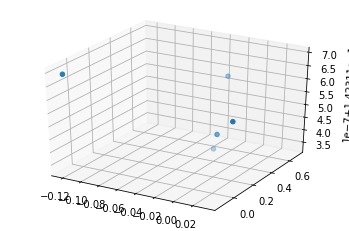

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-EEPosition[:,1], EEPosition[:,2], -EEPosition[:,0])
plt.show()

## orientation dictionary work

In [24]:
EEOrientation.shape


(4096, 3)

In [ ]:
import transforms3d as t3d
import numpy as np

def quantizeOrientationsBins(numBins, quaternions):
    #numBins is per axis --> numBins**2
    #using spherical coordinates: https://en.wikipedia.org/wiki/Spherical_coordinate_system
    #theta 0 is - pi/2 to pi/2
    #phi is -pi to pi
    #orientations is in quaternions
    
    quaternions = np.roll(quaternions, 1).copy()#we need w, x, y, z; vrep uses x, y, z, w
    
    thetaInterval = np.linspace(-np.pi/2, np.pi/2, num=numBins+1)
    phiInterval = np.linspace(-np.pi, np.pi, num=numBins+1)
    
    spherical = np.zeros((quaternions.shape[0],2)) #phi, theta
    for i in range(spherical.shape[0]):
        rotMat = t3d.quaternions.quat2mat(quaternions[i,:])
        cartesian = rotMat@np.ones((3,1))
        spherical[i,0] = np.arctan2(cartesian[1], cartesian[0]) # phi
        spherical[i,1] = np.arctan2(np.sqrt(cartesian[0]**2 + cartesian[1]**2), cartesian[2]) - np.pi/2 # theta
        
    binCounts = np.zeros((numBins,numBins))
    for i in range(numBins):
        for j in range(numBins):
            temp = np.stack((np.logical_and(spherical[:,1] > thetaInterval[i], spherical[:,1] < thetaInterval[i+1]),
                             np.logical_and(spherical[:,0] > phiInterval[j], spherical[:,0] < phiInterval[j+1])), axis = 1)
            #print(temp.shape)
            temp = temp.all(axis=1)
            binCounts[i,j] = np.sum(temp)
    return binCounts, spherical, temp, thetaInterval, phiInterval

binCounts, spherical, temp, thetaInterval, phiInterval = quantizeOrientationsBins(4, EEQuaternion)

print(binCounts)

In [ ]:
start = time.time()
for i in range(1000):
    binCounts, spherical, temp, thetaInterval, phiInterval = quantizeOrientationsBins(4, EEQuaternion) 
end = time.time()
end - start

